In [1]:
# Import all required libraries
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
numpy.random.seed(7)

In [2]:
# Load the dataset
inpath = './kolkata-pm2.5-calibrated.csv'
dataframe = pd.read_csv(inpath,usecols=[10], engine='python')

dataframe.dropna(inplace=True)
dataframe.isna().sum()

Ghusuri, Howrah - WBPCB    0
dtype: int64

In [3]:
dataset = dataframe.values
dataset = dataset.astype('float32')
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:
# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6131 3021


In [5]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [6]:
# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [7]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(8, return_sequences = True,input_shape=(1, look_back)))
model.add(LSTM(4,input_shape = (trainX.shape[1], 2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000
6129/6129 - 9s - loss: 0.0020
Epoch 2/1000
6129/6129 - 9s - loss: 9.5423e-04
Epoch 3/1000
6129/6129 - 9s - loss: 9.2251e-04
Epoch 4/1000
6129/6129 - 9s - loss: 9.0767e-04
Epoch 5/1000
6129/6129 - 9s - loss: 9.2571e-04
Epoch 6/1000
6129/6129 - 9s - loss: 9.0840e-04
Epoch 7/1000
6129/6129 - 9s - loss: 9.2089e-04
Epoch 8/1000
6129/6129 - 9s - loss: 9.0352e-04
Epoch 9/1000
6129/6129 - 9s - loss: 9.1153e-04
Epoch 10/1000
6129/6129 - 9s - loss: 9.0650e-04
Epoch 11/1000
6129/6129 - 9s - loss: 9.0925e-04
Epoch 12/1000
6129/6129 - 9s - loss: 9.0782e-04
Epoch 13/1000
6129/6129 - 9s - loss: 9.1162e-04
Epoch 14/1000
6129/6129 - 9s - loss: 8.9254e-04
Epoch 15/1000
6129/6129 - 9s - loss: 9.0059e-04
Epoch 16/1000
6129/6129 - 9s - loss: 9.0452e-04
Epoch 17/1000
6129/6129 - 9s - loss: 9.0325e-04
Epoch 18/1000
6129/6129 - 9s - loss: 9.0313e-04
Epoch 19/1000
6129/6129 - 9s - loss: 9.0589e-04
Epoch 20/1000
6129/6129 - 9s - loss: 9.0212e-04
Epoch 21/1000
6129/6129 - 9s - loss: 8.9978e-04
Epoch

In [8]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

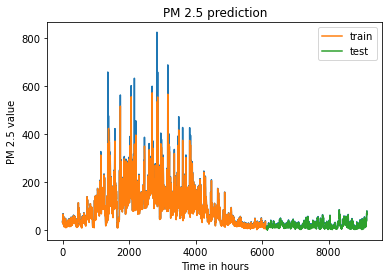

In [9]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,label='test')
plt.xlabel('Time in hours')
plt.ylabel('PM 2.5 value')
plt.title("PM 2.5 prediction")
plt.legend()
plt.show()

In [10]:
print(trainScore,testScore)

22.999441521070196 4.587798294394528


In [11]:
testPredictPlot

array([[     nan],
       [     nan],
       [     nan],
       ...,
       [63.57281],
       [78.46943],
       [     nan]], dtype=float32)

In [12]:
trainPredictPlot

array([[      nan],
       [34.001442],
       [31.736208],
       ...,
       [      nan],
       [      nan],
       [      nan]], dtype=float32)